In [15]:
import numpy as np
from engine import AdvRw2, AdvRwGridworld, CoinGame
from agent import ExpSmoother, FPLearningAgent, Level2QAgent, RandomAgent, IndQLearningAgent
from agent_differentiable import RegressionIndQLearningSoftmax
from agent import Level3QAgent, Level3QAgentMixExp, Level3QAgentMixDir, IndQLearningAgentSoftmax, Level2QAgentSoftmax
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot(r0ss, r1ss, dir=None):
    # We set a fancy theme
    plt.style.use('ggplot')
    N_EXP = len(r0ss)
    #plt.axis([0, max_steps*n_iter, -4.5, 1.5])
    for i in range(N_EXP):
        plt.plot(moving_average(r0ss[i], 500), 'b', alpha=0.05)
        plt.plot(moving_average(r1ss[i], 500), 'r', alpha=0.05)

    plt.plot(moving_average(np.asarray(r0ss).mean(axis=0), 500), 'b', alpha=0.5)
    plt.plot(moving_average(np.asarray(r1ss).mean(axis=0), 500), 'r', alpha=0.5)

    plt.xlabel('t');
    plt.ylabel('R');

    from matplotlib.lines import Line2D
    cmap = plt.cm.coolwarm
    custom_lines = [Line2D([0], [0], color='b'),
                    Line2D([0], [0], color='r')]

    #plt.legend(custom_lines,['Agent A']);
    if dir is not None:
        plt.savefig(dir + '.png')

0
1
2
3
4


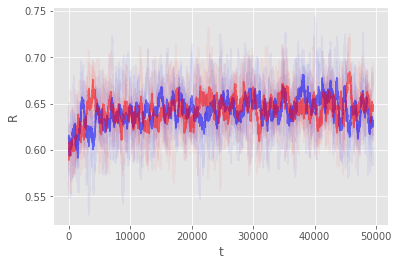

In [27]:
N_EXP = 5

r0ss = []
r1ss = []
#
for n in range(N_EXP):

    gamma = 0.99

    env = CoinGame(max_steps=6, tabular=False)
    n_states = (3*3)**4
    ##
    # P2 = ExpSmoother(env.available_actions_Adv, env.available_actions_Adv, learning_rate=0.7)
    P2 = RandomAgent( env.available_actions, p=0.5)
    
    P2 = RegressionIndQLearningSoftmax(env.available_actions_Adv, n_states, learning_rate=.001,
                           epsilon=0.1, gamma=gamma, enemy_action_space=None)
    P1 = RegressionIndQLearningSoftmax(env.available_actions_DM, n_states, learning_rate=.001,
                           epsilon=0.1, gamma=gamma, enemy_action_space=None)
    #P1 = Level2QAgentSoftmax(env.available_actions_DM, env.available_actions_Adv, n_states=n_states,
    #                   learning_rate=.9, epsilon=0.1, gamma=gamma)

    
    n_iter = 50000        


    r0s = []
    r1s = []
    
    
    for i in range(n_iter):
        
        #if i % 1000 == 0:
        #    print(i)

        # A full episode:
        done = False
        env.reset()
        s = env.get_state()
        
        episode_rewards_DM = 0
        episode_rewards_Adv = 0
            
        while not done:
            

            # Agents decide
            a1 = P1.act(s)
            a2 = P2.act(s)
            # This is to test the neutral adversary
            #a2 = np.random.choice(2, p=[0.9, 0.1])


            # World changes
            s_new, rewards, done =  env.step([a1,a2])


            # Agents learn

            P1.update(s, [a1, a2], [rewards[0], rewards[1]], s_new)
            P2.update(s, [a2, a1], [rewards[1], rewards[0]], s_new)
            
            s = s_new  
            #print(r0, r1)
            episode_rewards_DM += rewards[0]
            episode_rewards_Adv += rewards[1]
            
            
        r0s.append(episode_rewards_DM)
        r1s.append(episode_rewards_Adv)
        env.reset()
        if i%10 == 0:
            P1.epsilon *= 0.995
            P2.epsilon *= 0.995
            #P1.epsilonB *= 0.9
        
    print(n)
    r0ss.append(r0s)
    r1ss.append(r1s)
    
plot(r0ss, r1ss)

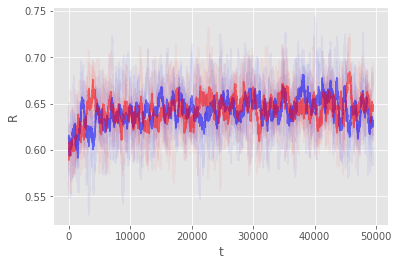

In [28]:
plot(r0ss, r1ss)